# Analisis Sentimen Terhadap Komentar Video Youtube Rewind Indonesia 2015

```
IDENTITAS

Nama  :
NIM   :
```

### Inisialisasi API KEY & VIDEO ID

In [8]:
DEVELOPER_KEY = "<Tulis Disini>"
VIDEO_ID = "<Tulis Disini>"

## Data Collecting

### Install Library

In [9]:
!pip install pandas
!pip install google-api-python-client


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Library

In [10]:
import time
import csv
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

### Collect data

In [11]:
# Menentukan parameter yang diperlukan, seperti nama layanan API dan versi, serta kunci pengembang
api_service_name = "youtube"
api_version = "v3"

# Membangun klien YouTube dengan menggunakan kunci pengembang
youtube = build(api_service_name, api_version, developerKey=DEVELOPER_KEY)

# Menginisialisasi variabel yang akan digunakan
max_results = 50  # menetapkan jumlah maksimum komentar yang diambil dalam satu permintaan API

# Menginisialisasi file CSV untuk menyimpan komentar
csv_filename = "raw_comments.csv"
csv_file = open(csv_filename, mode='w', newline='', encoding='utf-8')
csv_writer = csv.writer(csv_file)

# Variabel untuk melacak apakah header sudah ditulis
header_written = False

# Fungsi untuk menulis data ke CSV, menerima dictionary (JSON) dan menulis semua kuncinya
def write_to_csv(data, is_reply=False):
    global header_written  # Menandakan bahwa kita akan memodifikasi variabel global
    if isinstance(data, dict):
        # Menambahkan flag 'is_reply' ke data
        data['is_reply'] = is_reply
        # Menulis header jika belum pernah ditulis
        if not header_written:
            header = list(data.keys())
            csv_writer.writerow(header)
            header_written = True  # Setel flag header_written menjadi True
        # Menulis data ke CSV sesuai urutan header
        csv_writer.writerow([data.get(key, "") for key in data.keys()])

def get_replies(parent_id):
    """Mengambil balasan untuk komentar tertentu."""
    next_page_token_replies = None

    while True:
        response_replies = youtube.comments().list(
            part="snippet",
            parentId=parent_id,
            maxResults=max_results,
            pageToken=next_page_token_replies
        ).execute()

        for reply in response_replies['items']:
            reply_comment = reply['snippet']
            # Menyimpan balasan ke CSV
            write_to_csv(reply_comment, is_reply=True)

        next_page_token_replies = response_replies.get('nextPageToken')
        if not next_page_token_replies:
            break

next_page_token = None

while True:  # Loop ini akan terus berjalan sampai tidak ada halaman komentar berikutnya yang tersedia
    try:
        # Mengirim permintaan untuk mendapatkan komentar
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=VIDEO_ID,
            maxResults=max_results,  # Jumlah maksimum komentar yang diambil dalam satu permintaan
            pageToken=next_page_token  # Token halaman berikutnya yang digunakan untuk mendapatkan halaman komentar berikutnya
        )
        response = request.execute()  # Menjalankan permintaan dan menyimpan respons dari API ke dalam variabel response

        counter = 1
        # Menyimpan informasi komentar ke dalam list
        for item in response['items']:  # Mengambil daftar komentar dari respons API
            comment = item['snippet']['topLevelComment']['snippet']
            # Menulis komentar utama ke CSV
            write_to_csv(comment, is_reply=False)

            # Mengambil balasan dari komentar utama jika ada
            if 'replies' in item:
                get_replies(item['id'])

        # Memeriksa apakah ada halaman komentar berikutnya
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    except HttpError as e:
        if e.resp.status == 404:
            print(f"Video dengan ID {VIDEO_ID} tidak ditemukan.")
            break
        elif e.resp.status in [500, 502, 503, 504]:
            print("Server error occurred, retrying in 5 seconds...")
            time.sleep(5)
            continue
        else:
            print(f"An HTTP error {e.resp.status} occurred: {e.content}")
            break
    except TimeoutError as e:
        print("Timeout occurred, retrying in 5 seconds...")
        time.sleep(5)  # Tunggu beberapa detik sebelum mencoba lagi
        continue

# Menutup file CSV setelah semua komentar diambil
csv_file.close()

print(f"Komentar berhasil diambil dan disimpan ke {csv_filename}")


Komentar berhasil diambil dan disimpan ke youtube_comments.csv


## Data Preprocessing

In [2]:
!pip install pandas


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
import os
import re

In [4]:
raw_df = pd.read_csv("./raw_comments.csv")
raw_df.sample(5)

,channelId,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,is_reply
7927,UC-z1ubmS-iHMVr83EEwRS2g,iya benerr,iya benerr,UgxLGSm6oW9EsXSlew54AaABAg,@qk510,https://yt3.ggpht.com/ytc/AIdro_kBqLWo5g5a3cfi...,http://www.youtube.com/@qk510,{'value': 'UCk5LekVQ-SHdbRoVyieXWPQ'},True,none,0,2020-07-18T18:07:51Z,2020-07-18T18:07:51Z,True
18214,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,00.12m,00.12m,@miqbalpradityaoscar6319,https://yt3.ggpht.com/ytc/AIdro_mg7P11YSNen3EB...,http://www.youtube.com/@miqbalpradityaoscar6319,{'value': 'UCu68iHI8a-C-w5-F-u2jfpw'},True,none,0,2017-06-10T17:26:31Z,2017-06-10T17:26:31Z,False
15423,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Kangen masa masa 2015 :&#39;)<br>Kangen arapp:...,Kangen masa masa 2015 :')\nKangen arapp:')\nKa...,@putek3784,https://yt3.ggpht.com/ytc/AIdro_luG6oI2ieLs3Gp...,http://www.youtube.com/@putek3784,{'value': 'UC-fYJmoBeRdBdinuGP2rhXQ'},True,none,0,2018-12-07T07:09:03Z,2018-12-07T07:09:03Z,False
20672,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,nungguin yg 2k16 neh :v,nungguin yg 2k16 neh :v,@adityaharis8215,https://yt3.ggpht.com/ytc/AIdro_lLdJP7lFK420GE...,http://www.youtube.com/@adityaharis8215,{'value': 'UCEElf-8XEkeM53NFg2QbPIg'},True,none,0,2016-12-08T09:26:36Z,2016-12-08T09:26:36Z,False
9951,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,2019 ada yang ada like dong,2019 ada yang ada like dong,@arvinnata7519,https://yt3.ggpht.com/ytc/AIdro_khq6JsrgW7YB2i...,http://www.youtube.com/@arvinnata7519,{'value': 'UC57w1T-n3uvewtaM4-3ZQmQ'},True,none,1,2019-12-13T00:17:50Z,2019-12-13T00:17:50Z,False


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39712 entries, 0 to 39711
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   channelId              39712 non-null  object
 1   videoId                39712 non-null  object
 2   textDisplay            39702 non-null  object
 3   textOriginal           39702 non-null  object
 4   authorDisplayName      39709 non-null  object
 5   authorProfileImageUrl  39712 non-null  object
 6   authorChannelUrl       39712 non-null  object
 7   authorChannelId        39712 non-null  object
 8   canRate                39712 non-null  bool  
 9   viewerRating           39712 non-null  object
 10  likeCount              39712 non-null  int64 
 11  publishedAt            39712 non-null  object
 12  updatedAt              39712 non-null  object
 13  is_reply               39712 non-null  bool  
dtypes: bool(2), int64(1), object(11)
memory usage: 3.7+ MB


### Menghapus data yang memiliki "textOriginal" duplikat

In [6]:
raw_df = raw_df.drop_duplicates(subset=['textOriginal'])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28473 entries, 0 to 39710
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   channelId              28473 non-null  object
 1   videoId                28473 non-null  object
 2   textDisplay            28472 non-null  object
 3   textOriginal           28472 non-null  object
 4   authorDisplayName      28471 non-null  object
 5   authorProfileImageUrl  28473 non-null  object
 6   authorChannelUrl       28473 non-null  object
 7   authorChannelId        28473 non-null  object
 8   canRate                28473 non-null  bool  
 9   viewerRating           28473 non-null  object
 10  likeCount              28473 non-null  int64 
 11  publishedAt            28473 non-null  object
 12  updatedAt              28473 non-null  object
 13  is_reply               28473 non-null  bool  
dtypes: bool(2), int64(1), object(11)
memory usage: 2.9+ MB


### Menghapus data author yang duplikat

In [7]:
raw_df = raw_df.drop_duplicates(subset=['authorChannelUrl'])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25439 entries, 0 to 39706
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   channelId              25439 non-null  object
 1   videoId                25439 non-null  object
 2   textDisplay            25438 non-null  object
 3   textOriginal           25438 non-null  object
 4   authorDisplayName      25437 non-null  object
 5   authorProfileImageUrl  25439 non-null  object
 6   authorChannelUrl       25439 non-null  object
 7   authorChannelId        25439 non-null  object
 8   canRate                25439 non-null  bool  
 9   viewerRating           25439 non-null  object
 10  likeCount              25439 non-null  int64 
 11  publishedAt            25439 non-null  object
 12  updatedAt              25439 non-null  object
 13  is_reply               25439 non-null  bool  
dtypes: bool(2), int64(1), object(11)
memory usage: 2.6+ MB


### Menghapus data yang memiliki atribut null

In [11]:
raw_df = raw_df.dropna()

# Melihat data yang kosong
raw_df.isnull().sum()

channelId                0
videoId                  0
textDisplay              0
textOriginal             0
authorDisplayName        0
authorProfileImageUrl    0
authorChannelUrl         0
authorChannelId          0
canRate                  0
viewerRating             0
likeCount                0
publishedAt              0
updatedAt                0
is_reply                 0
dtype: int64

In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25436 entries, 0 to 39706
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   channelId              25436 non-null  object
 1   videoId                25436 non-null  object
 2   textDisplay            25436 non-null  object
 3   textOriginal           25436 non-null  object
 4   authorDisplayName      25436 non-null  object
 5   authorProfileImageUrl  25436 non-null  object
 6   authorChannelUrl       25436 non-null  object
 7   authorChannelId        25436 non-null  object
 8   canRate                25436 non-null  bool  
 9   viewerRating           25436 non-null  object
 10  likeCount              25436 non-null  int64 
 11  publishedAt            25436 non-null  object
 12  updatedAt              25436 non-null  object
 13  is_reply               25436 non-null  bool  
dtypes: bool(2), int64(1), object(11)
memory usage: 2.6+ MB


### Fungsi untuk membersihkan teks dari beberapa pola yang umum ditemukan dalam data teks

In [14]:
def clean_data_text(text):
    # Menghapus username
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Menghapus hashtag
    text = re.sub(r'#\w+', '', text)
    # Menghapus angka
    text = re.sub(r'\d+', '', text)
    # Menghapus 'RT' (retweet)
    text = re.sub(r'RT[\s]+', '', text)
    # Menghapus URL
    text = re.sub(r'https?://\S+', '', text)
    # Menghapus karakter non-alfanumerik
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    # Menghapus spasi ekstra di awal dan akhir teks, serta spasi berlebih di antara kata
    text = re.sub(r'\s+', ' ', text).strip()
    # Mencari dan menghapus karakter tunggal yang terpisah dari kata-kata
    text = re.sub(r'\b\w\b', '', text)
    # Menghapus angka tunggal
    text = re.sub(r'\b\d+\b', '', text)
    # Menghapus karakter berulang, misalnya: 'aa', 'bbb', 'ccc'
    text = re.sub(r'(.)\1+', r'\1', text)
    # Menghapus emotikon
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
    return text

In [15]:
# Apply clean_data_text pada dataframe
# Menggunakan .loc untuk mengakses DataFrame
raw_df.loc[:, 'textOriginal'] = raw_df['textOriginal'].apply(clean_data_text)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25436 entries, 0 to 39706
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   channelId              25436 non-null  object
 1   videoId                25436 non-null  object
 2   textDisplay            25436 non-null  object
 3   textOriginal           25436 non-null  object
 4   authorDisplayName      25436 non-null  object
 5   authorProfileImageUrl  25436 non-null  object
 6   authorChannelUrl       25436 non-null  object
 7   authorChannelId        25436 non-null  object
 8   canRate                25436 non-null  bool  
 9   viewerRating           25436 non-null  object
 10  likeCount              25436 non-null  int64 
 11  publishedAt            25436 non-null  object
 12  updatedAt              25436 non-null  object
 13  is_reply               25436 non-null  bool  
dtypes: bool(2), int64(1), object(11)
memory usage: 2.6+ MB


### Fungsi untuk membersihkan teks dari kata yang hanya 1 huruf

In [16]:
def remove_single_letter_words(text):
    return re.sub(r'\b\w\b', '', text).strip()

In [17]:
# Apply remove_single_letter_words pada dataframe
# Menggunakan .loc untuk mengakses DataFrame
raw_df.loc[:, 'textOriginal'] = raw_df['textOriginal'].apply(remove_single_letter_words)

raw_df

,channelId,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,is_reply
0,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Era dimana youtube rewing isinya para yutuberr,Era dimana youtube rewing isinya para yutuber,@AnneEilish-hr9nw,https://yt3.ggpht.com/ytc/AIdro_lqybv1ymmQZzV-...,http://www.youtube.com/@AnneEilish-hr9nw,{'value': 'UCTXwKraZfPO08y7rZBf0yHQ'},True,none,0,2024-10-07T18:35:32Z,2024-10-07T18:35:32Z,False
1,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Aah good old days,Aah god old days,@perottolol5628,https://yt3.ggpht.com/ytc/AIdro_m9Pe9uc3YWerul...,http://www.youtube.com/@perottolol5628,{'value': 'UCBamlpW3bkg2kAkMLyLBPsQ'},True,none,0,2024-10-06T05:46:34Z,2024-10-06T05:46:34Z,False
2,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Thereal muka² YouTube....,Thereal muka YouTube,@Nam_elat_hadniaK,https://yt3.ggpht.com/K0osFrXWYYYHBJWyNAz_NGsY...,http://www.youtube.com/@Nam_elat_hadniaK,{'value': 'UCqRVMul9vC_YGAPQi8lOY2g'},True,none,0,2024-10-06T04:32:56Z,2024-10-06T04:32:56Z,False
3,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,gua dari 2024,gua dari,@Dafculpengenjp,https://yt3.ggpht.com/ytc/AIdro_mBVNsGOPmaU5A1...,http://www.youtube.com/@Dafculpengenjp,{'value': 'UCGpNh5bk5Z27NKA5tvhn-Ng'},True,none,0,2024-10-02T07:13:00Z,2024-10-02T07:13:00Z,False
4,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,era di mana bayu skak masih jadi raja youtuber...,era di mana bayu skak masih jadi raja youtuber...,@sukakucing9402,https://yt3.ggpht.com/ytc/AIdro_m9BOv9kU3ADnVf...,http://www.youtube.com/@sukakucing9402,{'value': 'UC1FY86P81rYhmD0rJ_38unA'},True,none,1,2024-09-30T13:17:05Z,2024-09-30T13:17:05Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39696,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,woeee,woe,@RomeuRomeu,https://yt3.ggpht.com/ytc/AIdro_l89DpymcWykSV_...,http://www.youtube.com/@RomeuRomeu,{'value': 'UCywxmUNmJNnzETIAw54viYQ'},True,none,0,2015-12-11T06:02:19Z,2015-12-11T06:02:19Z,False
39697,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,1,,@pricillaoktaviani2376,https://yt3.ggpht.com/ytc/AIdro_lIX3-HU6zaCl0Z...,http://www.youtube.com/@pricillaoktaviani2376,{'value': 'UC98NN86UraJjwWLqd_QtT7w'},True,none,0,2015-12-11T06:02:18Z,2015-12-11T06:02:18Z,False
39703,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,=))) kerenn,keren,@is9production372,https://yt3.ggpht.com/ytc/AIdro_moVOuLXRVzZPUt...,http://www.youtube.com/@is9production372,{'value': 'UCdylMqTdbUdQODmXR8DIccQ'},True,none,0,2015-12-11T06:02:11Z,2015-12-11T06:02:11Z,False
39704,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Mantep :v,Mantep,@GantplayBlogspot,https://yt3.ggpht.com/ytc/AIdro_nyQqIuJWFK6Ie5...,http://www.youtube.com/@GantplayBlogspot,{'value': 'UCBXwOMQdEC6untz3OtZPCUg'},True,none,0,2015-12-11T06:02:11Z,2015-12-11T06:02:11Z,False


### Memilih hanya 1000 data sebagai sampel dari keseluruhan dataset yang telah bersih

In [23]:
# # Memilih 1000 data secara acak
sampled_df = raw_df.sample(n=1000, random_state=42)

sampled_df

,channelId,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,is_reply
12694,UC-z1ubmS-iHMVr83EEwRS2g,betulllll,betulllll,UgwFUgCTbPrUdFoPuzVAaABAg,@Nadyaptrimalika,https://yt3.ggpht.com/vpAW-2kQOcQAulUVNmtGUkLu...,http://www.youtube.com/@Nadyaptrimalika,{'value': 'UCmflfItOSUWsHjHp0IwOf1Q'},True,none,0,2018-12-17T09:49:26Z,2018-12-17T09:49:26Z,True
20225,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Yang jelas liat nih hahha kocak tapi keren pus...,Yang jelas liat nih haha kocak tapi keren push...,@nugrohoprihatianto3772,https://yt3.ggpht.com/ytc/AIdro_lBoVzz7hJJ3wYI...,http://www.youtube.com/@nugrohoprihatianto3772,{'value': 'UC-ETsOT5mK-OfMNXa1OvXvg'},True,none,0,2016-12-13T03:22:43Z,2016-12-13T03:22:43Z,False
7714,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"Hi rich brian;) <a href=""https://www.youtube.c...",Hi rich brian,@sahrilimam5143,https://yt3.ggpht.com/ytc/AIdro_l_qUB7UGalothF...,http://www.youtube.com/@sahrilimam5143,{'value': 'UCQNVIQeoChjWypM20kCWZSw'},True,none,6,2020-07-27T18:43:14Z,2020-07-27T18:43:14Z,False
26953,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,keren banget anjink,keren banget anjink,@achmadraihan6625,https://yt3.ggpht.com/ytc/AIdro_mQOTcC5bo56tC7...,http://www.youtube.com/@achmadraihan6625,{'value': 'UC1ZWdSz72fwLDSQuYL_84Bw'},True,none,0,2016-01-26T09:18:56Z,2016-01-26T09:18:56Z,False
38526,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,siapa sih yang baju pink...??,siapa sih yang baju pink,@agungramadhani5989,https://yt3.ggpht.com/ytc/AIdro_mYy_jLX3ju_OCQ...,http://www.youtube.com/@agungramadhani5989,{'value': 'UCpFrh01aTnIy03eGJUy19DA'},True,none,0,2015-12-11T06:34:04Z,2015-12-11T06:34:04Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22929,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,aulion boom banget asli,aulion bom banget asli,@agungputra8945,https://yt3.ggpht.com/ytc/AIdro_nt8K_0roxHaO5y...,http://www.youtube.com/@agungputra8945,{'value': 'UCJZ1Vr3I5qwXNG7WyvOwBsA'},True,none,0,2016-07-02T03:35:09Z,2016-07-02T03:35:09Z,False
22697,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"detik <a href=""https://www.youtube.com/watch?v...",detik lagu apa ya makasih,@michellewilding9229,https://yt3.ggpht.com/ytc/AIdro_kjlWLima_4hKpf...,http://www.youtube.com/@michellewilding9229,{'value': 'UCafdjvr_a3q_ouZcUM-ahew'},True,none,0,2016-07-10T11:35:49Z,2016-07-10T11:35:49Z,False
299,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,2024 I&#39;m back again :),Im back again,@xZELL77,https://yt3.ggpht.com/05bI1gHQknowsPwiatxU1e1h...,http://www.youtube.com/@xZELL77,{'value': 'UCvY0NgbmTtzoUkZzAV_z0wA'},True,none,1,2024-01-14T07:39:32Z,2024-01-14T07:39:32Z,False
9259,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Throwback dimana youtube indonesia pure talent...,Throwback dimana youtube indonesia pure talent...,@daffawirat2721,https://yt3.ggpht.com/ytc/AIdro_njjjYgsJZHazYd...,http://www.youtube.com/@daffawirat2721,{'value': 'UCnfFnK1gLNGJl0DmBbxn0Eg'},True,none,0,2020-04-17T01:59:13Z,2020-04-17T01:59:13Z,False


### Normalisasi

In [19]:
norm = {
    " yg ": " yang ",
    " kren ": " keren",
    " sdh ": " sudah ",
    " dgn ": " dengan ",
    " tdk ": " tidak ",
    " dlm ": " dalam ",
    " dl ": " dulu ",
    " gw ": " saya ",
    " kok ": " kenapa ",
    " bs ": " bisa ",
    " bgt ": " sangat ",
    " njir ": " kagum ",
    " anjir ": " kagum ",
    " g ": " tidak ",
    " lg ": " lagi ",
    " dr ": " dari ",
    " tp ": " tapi ",
    " jg ": " juga ",
    " sm ": " sama ",
    " krn ": " karena ",
    " spt ": " seperti ",
    " yg ": " yang ",
    " pd ": " pada ",
    " dn ": " dan ",
    " d ": " di ",
    " kt ": " kita ",
    " km ": " kamu ",
    " ms ": " masih ",
    " tlg ": " tolong ",
    " sja ": " saja ",
    " sy ": " saya ",
    " sdikit ": " sedikit ",
    " dket ": " dekat ",
    " lbh ": " lebih ",
    " sj ": " saja ",
    " bnyk ": " banyak ",
    " dgnnya ": " dengannya ",
    " sgala ": " segala ",
    " skrg ": " sekarang ",
    " nmr ": " nomor ",
    " srg ": " sering ",
    " ttg ": " tentang ",
    " smua ": " semua ",
    " trus ": " terus ",
    " pdhl ": " padahal ",
    " kt ": " kita ",
    " dkt ": " dekat ",
    " jg ": " juga ",
    " dlm ": " dalam ",
    " bhw ": " bahwa ",
    " sja ": " saja ",
    " mrk ": " mereka ",
    " sgth ": " sangat ",
    " dn ": " dan ",
    " trlalu ": " terlalu ",
    " msing2 ": " masing-masing ",
    " brp ": " berapa ",
    " aq ": " aku ",
    " smpe ": " sampai ",
    " kalo ": " kalau ",
    " bkn ": " bukan ",
    " jd ": " jadi ",
    " dket ": " dekat ",
    " ntr ": " nanti ",
    " klo ": " kalau ",
    " sda ": " sudah ",
    " sy ": " saya ",
    " kpn ": " kapan ",
    " dmn ": " dimana ",
    " lgsng ": " langsung ",
    " tdk ": " tidak ",
    " pgi ": " pagi ",
    " ngga ": " tidak ",
    " gak ": " tidak ",
    " lbih ": " lebih ",
    " cm ": " cuman ",
    " sgt ": " sangat ",
    " aj ": " saja ",
    " apa2 ": " apa-apa ",
    " krg ": " kurang ",
    " ngerti ": " mengerti ",
    " slalu ": " selalu ",
    " bbrp ": " beberapa ",
    " smpe ": " sampai ",
    " krja ": " kerja ",
    " bbrp ": " beberapa ",
    " jln ": " jalan ",
    " hr ": " hari ",
    " kok ": " kenapa ",
    " mgkin ": " mungkin "
    # Tambahkan aturan normalisasi lainnya di sini sesuai kebutuhan
}

In [20]:
def normalisasi(text):
    for i in norm:
        text = text.replace(i, norm[i])
    return text

In [24]:
sampled_df.loc[:, 'textOriginal'] = sampled_df['textOriginal'].apply(normalisasi)

sampled_df

,channelId,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,is_reply
12694,UC-z1ubmS-iHMVr83EEwRS2g,betulllll,betulllll,UgwFUgCTbPrUdFoPuzVAaABAg,@Nadyaptrimalika,https://yt3.ggpht.com/vpAW-2kQOcQAulUVNmtGUkLu...,http://www.youtube.com/@Nadyaptrimalika,{'value': 'UCmflfItOSUWsHjHp0IwOf1Q'},True,none,0,2018-12-17T09:49:26Z,2018-12-17T09:49:26Z,True
20225,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Yang jelas liat nih hahha kocak tapi keren pus...,Yang jelas liat nih haha kocak tapi keren push...,@nugrohoprihatianto3772,https://yt3.ggpht.com/ytc/AIdro_lBoVzz7hJJ3wYI...,http://www.youtube.com/@nugrohoprihatianto3772,{'value': 'UC-ETsOT5mK-OfMNXa1OvXvg'},True,none,0,2016-12-13T03:22:43Z,2016-12-13T03:22:43Z,False
7714,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"Hi rich brian;) <a href=""https://www.youtube.c...",Hi rich brian,@sahrilimam5143,https://yt3.ggpht.com/ytc/AIdro_l_qUB7UGalothF...,http://www.youtube.com/@sahrilimam5143,{'value': 'UCQNVIQeoChjWypM20kCWZSw'},True,none,6,2020-07-27T18:43:14Z,2020-07-27T18:43:14Z,False
26953,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,keren banget anjink,keren banget anjink,@achmadraihan6625,https://yt3.ggpht.com/ytc/AIdro_mQOTcC5bo56tC7...,http://www.youtube.com/@achmadraihan6625,{'value': 'UC1ZWdSz72fwLDSQuYL_84Bw'},True,none,0,2016-01-26T09:18:56Z,2016-01-26T09:18:56Z,False
38526,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,siapa sih yang baju pink...??,siapa sih yang baju pink,@agungramadhani5989,https://yt3.ggpht.com/ytc/AIdro_mYy_jLX3ju_OCQ...,http://www.youtube.com/@agungramadhani5989,{'value': 'UCpFrh01aTnIy03eGJUy19DA'},True,none,0,2015-12-11T06:34:04Z,2015-12-11T06:34:04Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22929,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,aulion boom banget asli,aulion bom banget asli,@agungputra8945,https://yt3.ggpht.com/ytc/AIdro_nt8K_0roxHaO5y...,http://www.youtube.com/@agungputra8945,{'value': 'UCJZ1Vr3I5qwXNG7WyvOwBsA'},True,none,0,2016-07-02T03:35:09Z,2016-07-02T03:35:09Z,False
22697,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"detik <a href=""https://www.youtube.com/watch?v...",detik lagu apa ya makasih,@michellewilding9229,https://yt3.ggpht.com/ytc/AIdro_kjlWLima_4hKpf...,http://www.youtube.com/@michellewilding9229,{'value': 'UCafdjvr_a3q_ouZcUM-ahew'},True,none,0,2016-07-10T11:35:49Z,2016-07-10T11:35:49Z,False
299,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,2024 I&#39;m back again :),Im back again,@xZELL77,https://yt3.ggpht.com/05bI1gHQknowsPwiatxU1e1h...,http://www.youtube.com/@xZELL77,{'value': 'UCvY0NgbmTtzoUkZzAV_z0wA'},True,none,1,2024-01-14T07:39:32Z,2024-01-14T07:39:32Z,False
9259,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Throwback dimana youtube indonesia pure talent...,Throwback dimana youtube indonesia pure talent...,@daffawirat2721,https://yt3.ggpht.com/ytc/AIdro_njjjYgsJZHazYd...,http://www.youtube.com/@daffawirat2721,{'value': 'UCnfFnK1gLNGJl0DmBbxn0Eg'},True,none,0,2020-04-17T01:59:13Z,2020-04-17T01:59:13Z,False


### Mengubah data text menjadi lowercase

In [25]:
sampled_df['textOriginal'] = sampled_df['textOriginal'].str.lower()

sampled_df

,channelId,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,is_reply
12694,UC-z1ubmS-iHMVr83EEwRS2g,betulllll,betulllll,ugwfugctbprudfopuzvaaabag,@Nadyaptrimalika,https://yt3.ggpht.com/vpAW-2kQOcQAulUVNmtGUkLu...,http://www.youtube.com/@Nadyaptrimalika,{'value': 'UCmflfItOSUWsHjHp0IwOf1Q'},True,none,0,2018-12-17T09:49:26Z,2018-12-17T09:49:26Z,True
20225,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Yang jelas liat nih hahha kocak tapi keren pus...,yang jelas liat nih haha kocak tapi keren push...,@nugrohoprihatianto3772,https://yt3.ggpht.com/ytc/AIdro_lBoVzz7hJJ3wYI...,http://www.youtube.com/@nugrohoprihatianto3772,{'value': 'UC-ETsOT5mK-OfMNXa1OvXvg'},True,none,0,2016-12-13T03:22:43Z,2016-12-13T03:22:43Z,False
7714,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"Hi rich brian;) <a href=""https://www.youtube.c...",hi rich brian,@sahrilimam5143,https://yt3.ggpht.com/ytc/AIdro_l_qUB7UGalothF...,http://www.youtube.com/@sahrilimam5143,{'value': 'UCQNVIQeoChjWypM20kCWZSw'},True,none,6,2020-07-27T18:43:14Z,2020-07-27T18:43:14Z,False
26953,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,keren banget anjink,keren banget anjink,@achmadraihan6625,https://yt3.ggpht.com/ytc/AIdro_mQOTcC5bo56tC7...,http://www.youtube.com/@achmadraihan6625,{'value': 'UC1ZWdSz72fwLDSQuYL_84Bw'},True,none,0,2016-01-26T09:18:56Z,2016-01-26T09:18:56Z,False
38526,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,siapa sih yang baju pink...??,siapa sih yang baju pink,@agungramadhani5989,https://yt3.ggpht.com/ytc/AIdro_mYy_jLX3ju_OCQ...,http://www.youtube.com/@agungramadhani5989,{'value': 'UCpFrh01aTnIy03eGJUy19DA'},True,none,0,2015-12-11T06:34:04Z,2015-12-11T06:34:04Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22929,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,aulion boom banget asli,aulion bom banget asli,@agungputra8945,https://yt3.ggpht.com/ytc/AIdro_nt8K_0roxHaO5y...,http://www.youtube.com/@agungputra8945,{'value': 'UCJZ1Vr3I5qwXNG7WyvOwBsA'},True,none,0,2016-07-02T03:35:09Z,2016-07-02T03:35:09Z,False
22697,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"detik <a href=""https://www.youtube.com/watch?v...",detik lagu apa ya makasih,@michellewilding9229,https://yt3.ggpht.com/ytc/AIdro_kjlWLima_4hKpf...,http://www.youtube.com/@michellewilding9229,{'value': 'UCafdjvr_a3q_ouZcUM-ahew'},True,none,0,2016-07-10T11:35:49Z,2016-07-10T11:35:49Z,False
299,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,2024 I&#39;m back again :),im back again,@xZELL77,https://yt3.ggpht.com/05bI1gHQknowsPwiatxU1e1h...,http://www.youtube.com/@xZELL77,{'value': 'UCvY0NgbmTtzoUkZzAV_z0wA'},True,none,1,2024-01-14T07:39:32Z,2024-01-14T07:39:32Z,False
9259,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Throwback dimana youtube indonesia pure talent...,throwback dimana youtube indonesia pure talent...,@daffawirat2721,https://yt3.ggpht.com/ytc/AIdro_njjjYgsJZHazYd...,http://www.youtube.com/@daffawirat2721,{'value': 'UCnfFnK1gLNGJl0DmBbxn0Eg'},True,none,0,2020-04-17T01:59:13Z,2020-04-17T01:59:13Z,False


### Stopwords

In [26]:
!pip install Sastrawi


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

more_stop_words = ["tidak"]

stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

In [28]:
sampled_df.loc[:, 'textOriginal'] = sampled_df['textOriginal'].apply(stopword)

sampled_df

,channelId,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,is_reply
12694,UC-z1ubmS-iHMVr83EEwRS2g,betulllll,betulllll,ugwfugctbprudfopuzvaaabag,@Nadyaptrimalika,https://yt3.ggpht.com/vpAW-2kQOcQAulUVNmtGUkLu...,http://www.youtube.com/@Nadyaptrimalika,{'value': 'UCmflfItOSUWsHjHp0IwOf1Q'},True,none,0,2018-12-17T09:49:26Z,2018-12-17T09:49:26Z,True
20225,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Yang jelas liat nih hahha kocak tapi keren pus...,jelas liat nih haha kocak keren pushagrief fux...,@nugrohoprihatianto3772,https://yt3.ggpht.com/ytc/AIdro_lBoVzz7hJJ3wYI...,http://www.youtube.com/@nugrohoprihatianto3772,{'value': 'UC-ETsOT5mK-OfMNXa1OvXvg'},True,none,0,2016-12-13T03:22:43Z,2016-12-13T03:22:43Z,False
7714,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"Hi rich brian;) <a href=""https://www.youtube.c...",hi rich brian,@sahrilimam5143,https://yt3.ggpht.com/ytc/AIdro_l_qUB7UGalothF...,http://www.youtube.com/@sahrilimam5143,{'value': 'UCQNVIQeoChjWypM20kCWZSw'},True,none,6,2020-07-27T18:43:14Z,2020-07-27T18:43:14Z,False
26953,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,keren banget anjink,keren banget anjink,@achmadraihan6625,https://yt3.ggpht.com/ytc/AIdro_mQOTcC5bo56tC7...,http://www.youtube.com/@achmadraihan6625,{'value': 'UC1ZWdSz72fwLDSQuYL_84Bw'},True,none,0,2016-01-26T09:18:56Z,2016-01-26T09:18:56Z,False
38526,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,siapa sih yang baju pink...??,siapa sih baju pink,@agungramadhani5989,https://yt3.ggpht.com/ytc/AIdro_mYy_jLX3ju_OCQ...,http://www.youtube.com/@agungramadhani5989,{'value': 'UCpFrh01aTnIy03eGJUy19DA'},True,none,0,2015-12-11T06:34:04Z,2015-12-11T06:34:04Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22929,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,aulion boom banget asli,aulion bom banget asli,@agungputra8945,https://yt3.ggpht.com/ytc/AIdro_nt8K_0roxHaO5y...,http://www.youtube.com/@agungputra8945,{'value': 'UCJZ1Vr3I5qwXNG7WyvOwBsA'},True,none,0,2016-07-02T03:35:09Z,2016-07-02T03:35:09Z,False
22697,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,"detik <a href=""https://www.youtube.com/watch?v...",detik lagu apa makasih,@michellewilding9229,https://yt3.ggpht.com/ytc/AIdro_kjlWLima_4hKpf...,http://www.youtube.com/@michellewilding9229,{'value': 'UCafdjvr_a3q_ouZcUM-ahew'},True,none,0,2016-07-10T11:35:49Z,2016-07-10T11:35:49Z,False
299,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,2024 I&#39;m back again :),im back again,@xZELL77,https://yt3.ggpht.com/05bI1gHQknowsPwiatxU1e1h...,http://www.youtube.com/@xZELL77,{'value': 'UCvY0NgbmTtzoUkZzAV_z0wA'},True,none,1,2024-01-14T07:39:32Z,2024-01-14T07:39:32Z,False
9259,UC-z1ubmS-iHMVr83EEwRS2g,fNX6Gu2F7A8,Throwback dimana youtube indonesia pure talent...,throwback youtube indonesia pure talenthardwor...,@daffawirat2721,https://yt3.ggpht.com/ytc/AIdro_njjjYgsJZHazYd...,http://www.youtube.com/@daffawirat2721,{'value': 'UCnfFnK1gLNGJl0DmBbxn0Eg'},True,none,0,2020-04-17T01:59:13Z,2020-04-17T01:59:13Z,False


### Menyimpan sampled_df ke file csv

In [29]:
sampled_df.to_csv("sampled_comments.csv")

## Data Splitting

In [4]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
file_path = 'labeled_comments.csv'
df = pd.read_csv(file_path)

# Memastikan bahwa kolom 'label' ada dan sudah terisi
if 'label' not in df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan dalam dataset")

# Filter data berdasarkan label
positif_df = df[df['label'] == 'positif']
netral_df = df[df['label'] == 'netral']
negatif_df = df[df['label'] == 'negatif']

# Ambil 100 sampel acak dari masing-masing label
sample_positif = positif_df.sample(n=100, random_state=42)  # random_state untuk reproducibility
sample_netral = netral_df.sample(n=100, random_state=42)
sample_negatif = negatif_df.sample(n=100, random_state=42)

# Gabungkan ketiga sampel
sampled_data = pd.concat([sample_positif, sample_netral, sample_negatif])

# Bagi data menjadi 80% untuk training dan 20% untuk testing
train_data, test_data = train_test_split(sampled_data, test_size=0.2, random_state=42, stratify=sampled_data['label'])

# Simpan data training dan testing ke file CSV terpisah
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print(f"Data training berjumlah {len(train_data)} data disimpan di 'train_data.csv'.")
print(f"Data testing berjumlah {len(test_data)} data disimpan di 'test_data.csv'.")

Data training berjumlah 240 data disimpan di 'train_data.csv'.
Data testing berjumlah 60 data disimpan di 'test_data.csv'.


## Data Analysis

### Train model dengan Naive Bayes 

In [6]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

In [10]:
# Misalkan df_train dan df_test sudah didefinisikan sebelumnya
# Memisahkan fitur dan label dari data training dan testing
X_train = df_train['textOriginal']
y_train = df_train['label']
X_test = df_test['textOriginal']
y_test = df_test['label']

# Menggunakan TfidfVectorizer untuk mengubah teks menjadi fitur
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Menggunakan SMOTE untuk melakukan oversampling pada data latih
smote = SMOTE(random_state=42)
X_train_tfidf_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Melatih model menggunakan data train yang telah di-oversample
model = MultinomialNB()
model.fit(X_train_tfidf_res, y_train_res)

# Memprediksi data test
y_test_pred = model.predict(X_test_tfidf)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Akurasi model: {accuracy}")

# Mencetak classification report
report = classification_report(y_test, y_test_pred)
print(f"Classification Report:\n{report}")

# Menyimpan model dan vectorizer
joblib.dump(model, 'model_nb.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Model dan vectorizer telah disimpan.")

Akurasi model: 0.5166666666666667
Classification Report:
              precision    recall  f1-score   support

     negatif       0.43      0.45      0.44        20
      netral       0.53      0.45      0.49        20
     positif       0.59      0.65      0.62        20

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.51        60
weighted avg       0.52      0.52      0.51        60

Model dan vectorizer telah disimpan.


**Model yang baik memiliki akurasi > 85%. Model di atas hanya contoh karena akurasinya yang buruk disebabkan karena kurangnya proses normalisasi dan kesalahan inkonsistensi label**

### Memprediksi semua data dengan model

In [11]:
import pandas as pd
import joblib  # Untuk memuat model dan vectorizer yang sudah diekspor sebelumnya

# Load vectorizer dan model yang telah diekspor sebelumnya
vectorizer = joblib.load("vectorizer.pkl")  # Pastikan ini adalah path ke file vectorizer
model = joblib.load("model_nb.pkl")  # Pastikan ini adalah path ke file model Naive Bayes

# Membuat DataFrame dari data sampled_comments.csv
df_unlabeled = pd.read_csv("sampled_comments.csv")

# Menggunakan vectorizer yang sama seperti yang digunakan untuk training
# Pastikan kolom 'textOriginal' ada dan diubah ke string jika diperlukan
X_unlabeled = vectorizer.transform(df_unlabeled['textOriginal'].astype(str))  

# Melakukan prediksi label untuk data yang belum memiliki label
y_pred_unlabeled = model.predict(X_unlabeled)

# Menambahkan hasil prediksi label ke DataFrame
df_unlabeled['predicted_label'] = y_pred_unlabeled

# Simpan hasil prediksi ke file CSV
df_unlabeled.to_csv("sampled_comments_with_predictions.csv", index=False)

print("Proses prediksi selesai dan hasil disimpan ke 'sampled_comments_with_predictions.csv'.")


Proses prediksi selesai dan hasil disimpan ke 'sampled_comments_with_predictions.csv'.


## Data Visualitation

In [25]:
!pip install matplotlib
!pip install wordcloud


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt

In [13]:
# Load dataset
df = pd.read_csv("sampled_comments_with_predictions.csv")

# Filter data untuk label positif, netral, dan negatif
df_positive = df[df['predicted_label'] == 'positif']
df_netral = df[df['predicted_label'] == 'netral']
df_negative = df[df['predicted_label'] == 'negatif']

### Bar Chart

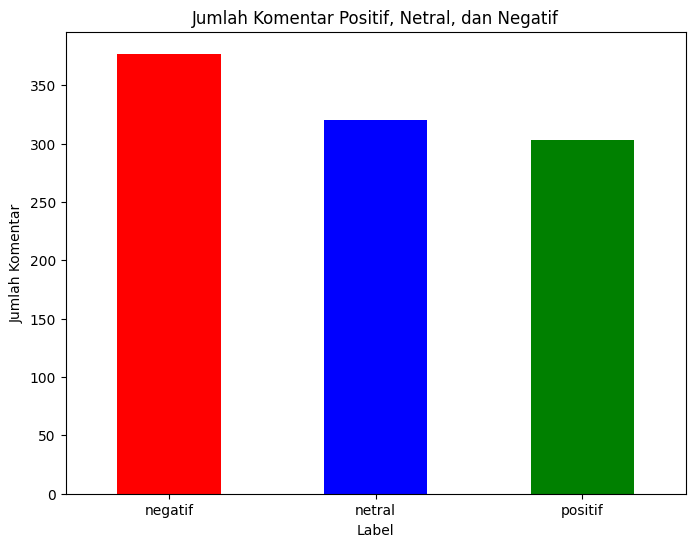

In [16]:
counts = df['predicted_label'].value_counts()

# Plot barchart
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Jumlah Komentar Positif, Netral, dan Negatif')
plt.xlabel('Label')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=0)
plt.show()

### Line Chart

<Figure size 1000x600 with 0 Axes>

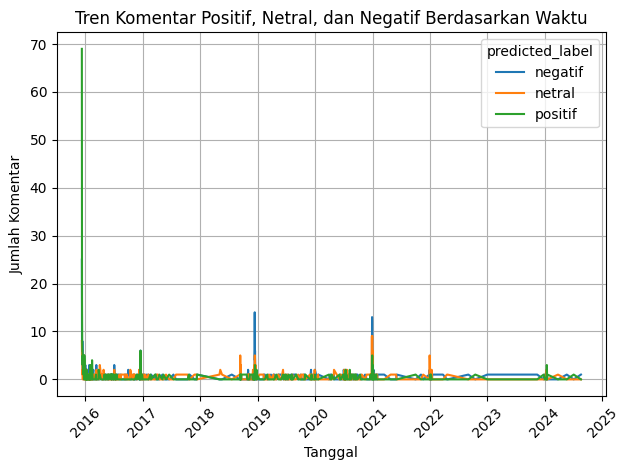

In [18]:
# Pastikan kolom 'publishedAt' adalah tipe datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Group by tanggal dan label
df_grouped = df.groupby([df['publishedAt'].dt.date, 'predicted_label']).size().unstack(fill_value=0)

# Plot linechart
plt.figure(figsize=(10, 6))
df_grouped.plot(kind='line')
plt.title('Tren Komentar Positif, Netral, dan Negatif Berdasarkan Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Komentar')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Pie Chart

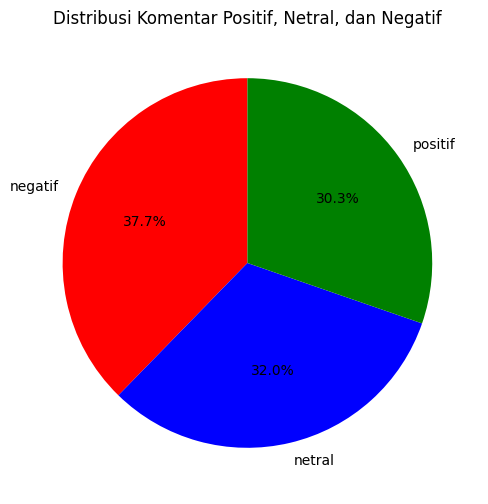

In [21]:
# Plot pie chart
plt.figure(figsize=(8, 6))
counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'blue', 'green'], startangle=90)
plt.title('Distribusi Komentar Positif, Netral, dan Negatif')
plt.ylabel('')  # Menghilangkan label sumbu y
plt.show()

### WordCloud

In [23]:
from wordcloud import WordCloud

In [27]:
# Gabungkan semua teks komentar positif dan negatif
text_positive = " ".join(comment for comment in df_positive['textOriginal'].astype(str))
text_negative = " ".join(comment for comment in df_negative['textOriginal'].astype(str))

# Generate wordcloud untuk komentar positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_positive)

# Generate wordcloud untuk komentar negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_negative)

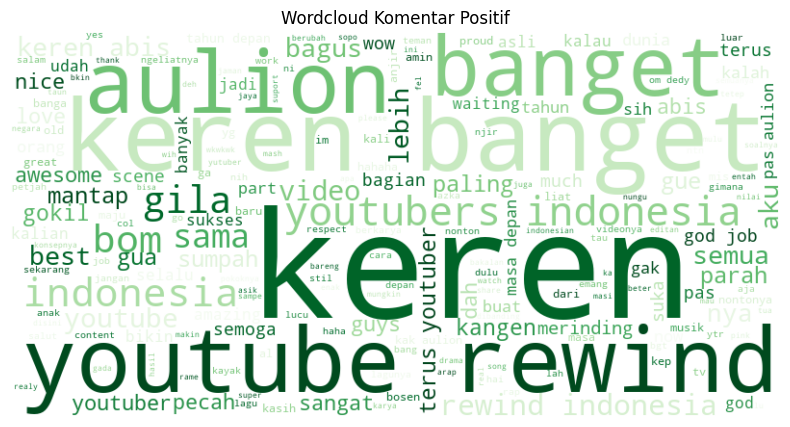

In [28]:
# Plot wordcloud positif
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Komentar Positif')
plt.show()

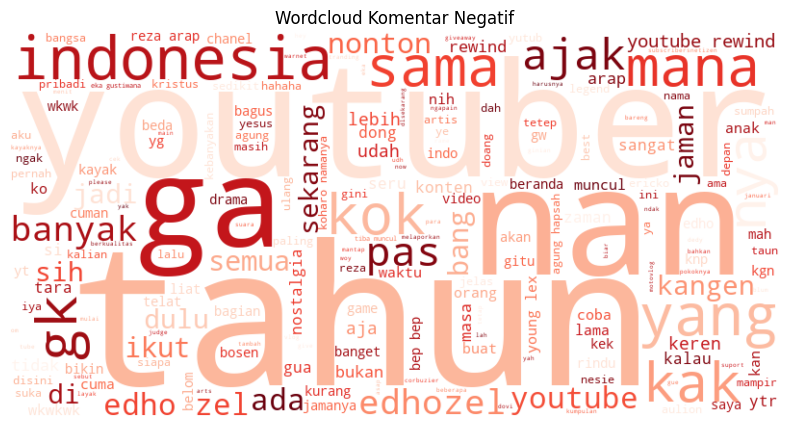

In [29]:
# Plot wordcloud negatif
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Komentar Negatif')
plt.show()

## Conclusion

Berdasarkan proses analisis yang dilakukan terhadap komentar video Youtube Rewind Indonesia 2015, maka dapat dijelaskan sebagai berikut

- Data yang diperoleh sebanyak 45.287 (`raw_comments.csv`)
- Data sampel yang akan dianalisis sebanyak 1000 (`sampled_comments.csv`)
- Data yang diberikan label sebanyak 300 atau masing-masing 100 untuk setiap kelas dengan rincian:
    - 240 data training (80%) (`train_data.csv`)
    - 60 data testing (20%) (`test_data.csv`)
- Data yang akan diprediksi labelnya sebanyak 700 (1000 raw data - 300 data yang sudah dilabel)

**Kesimpulan:**

- Akurasi model sebesar ... (sebaiknya di atas 85%)
- Hasil prediksi:
    - Positif: 30.3%
    - Negatif: 37.7%
    - Netral: 32.0%
- Kata yang paling dominan dalam komentar positif seperti keren, banget, dan mantap
- Kata yang paling dominan dalam komentar negatif seperti kok, bukan, dan ga

**=== Finish ===**